# Projet CV : Classification de races de chiens

In [84]:
# Import libraries
import os, shutil, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tqdm

import warnings
warnings.filterwarnings('ignore')

## Helpers

In [85]:
import xml.etree.ElementTree as ET

def dog_breed_annotations(dog, breed):
    
    tree = ET.parse(annotations_dir + breed + '/' + dog)
    
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
   
    return xmin, xmax, ymin, ymax


def crop_image(breed, dog, img):
    
    xmin, xmax, ymin, ymax = dog_breed_annotations(dog, breed)
    crop_img = img[ymin:ymax, xmin:xmax, :]
    
    return crop_img

In [87]:
def listToString(s):
    # initialize an empty string
    str1 = ","
    # return string
    return (str1.join(s))

# Préparation des données

**first difficulty of dataset: all images not same size**

## Présentation 

In [89]:
# Define path to data
annotations_dir = '/Users/souha_kassab/OC_P6/static/data/Annotation/' 
images_dir = '/Users/souha_kassab/OC_P6/static/data/Images/'

In [90]:
# Count the number of classes (dogs breeds)
breed_names = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_names)))

Number of breeds in dataset: 121


In [120]:
breed_annotations = os.listdir(annotations_dir)
print("Number of annotated breeds in dataset:", (len(breed_annotations)))

Number of annotated breeds in dataset: 121


In [91]:
breed_names
breed_names.remove('.DS_Store')
breed_names

['n02097658-silky_terrier',
 'n02092002-Scottish_deerhound',
 'n02099849-Chesapeake_Bay_retriever',
 'n02091244-Ibizan_hound',
 'n02095314-wire-haired_fox_terrier',
 'n02091831-Saluki',
 'n02102318-cocker_spaniel',
 'n02104365-schipperke',
 'n02090622-borzoi',
 'n02113023-Pembroke',
 'n02105505-komondor',
 'n02093256-Staffordshire_bullterrier',
 'n02113799-standard_poodle',
 'n02109961-Eskimo_dog',
 'n02089973-English_foxhound',
 'n02099601-golden_retriever',
 'n02095889-Sealyham_terrier',
 'n02085782-Japanese_spaniel',
 'n02097047-miniature_schnauzer',
 'n02110063-malamute',
 'n02105162-malinois',
 'n02086079-Pekinese',
 'n02097130-giant_schnauzer',
 'n02113978-Mexican_hairless',
 'n02107142-Doberman',
 'n02097209-standard_schnauzer',
 'n02115913-dhole',
 'n02106662-German_shepherd',
 'n02106382-Bouvier_des_Flandres',
 'n02110185-Siberian_husky',
 'n02094258-Norwich_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02109525-Saint_Bernard',
 'n02093754-Border_terri

In [129]:
Doglabels_dict = {x[:9]: x[10:] for x in breed_names}
Doglabels_dict

{'n02097658': 'silky_terrier',
 'n02092002': 'Scottish_deerhound',
 'n02099849': 'Chesapeake_Bay_retriever',
 'n02091244': 'Ibizan_hound',
 'n02095314': 'wire-haired_fox_terrier',
 'n02091831': 'Saluki',
 'n02102318': 'cocker_spaniel',
 'n02104365': 'schipperke',
 'n02090622': 'borzoi',
 'n02113023': 'Pembroke',
 'n02105505': 'komondor',
 'n02093256': 'Staffordshire_bullterrier',
 'n02113799': 'standard_poodle',
 'n02109961': 'Eskimo_dog',
 'n02089973': 'English_foxhound',
 'n02099601': 'golden_retriever',
 'n02095889': 'Sealyham_terrier',
 'n02085782': 'Japanese_spaniel',
 'n02097047': 'miniature_schnauzer',
 'n02110063': 'malamute',
 'n02105162': 'malinois',
 'n02086079': 'Pekinese',
 'n02097130': 'giant_schnauzer',
 'n02113978': 'Mexican_hairless',
 'n02107142': 'Doberman',
 'n02097209': 'standard_schnauzer',
 'n02115913': 'dhole',
 'n02106662': 'German_shepherd',
 'n02106382': 'Bouvier_des_Flandres',
 'n02110185': 'Siberian_husky',
 'n02094258': 'Norwich_terrier',
 'n02093991': 'Ir

In [93]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(index= list(Doglabels_dict.values()),
                         #breed_names,
                         data=[len(os.listdir(images_dir + breed_name)) for breed_name in breed_names],
                         columns=["num_pictures"])

In [94]:
df_breeds = df_breeds.sort_values(by=['num_pictures'], ascending=False)
df_breeds.T

,Maltese_dog,Afghan_hound,Scottish_deerhound,Pomeranian,Bernese_mountain_dog,Samoyed,Irish_wolfhound,Shih-Tzu,Great_Pyrenees,Leonberg,...,Bouvier_des_Flandres,kuvasz,golden_retriever,affenpinscher,clumber,Welsh_springer_spaniel,malinois,Border_collie,Pekinese,redbone
num_pictures,252,239,232,219,218,218,218,214,213,210,...,150,150,150,150,150,150,150,150,149,148


The number of remaining pictures is 20580


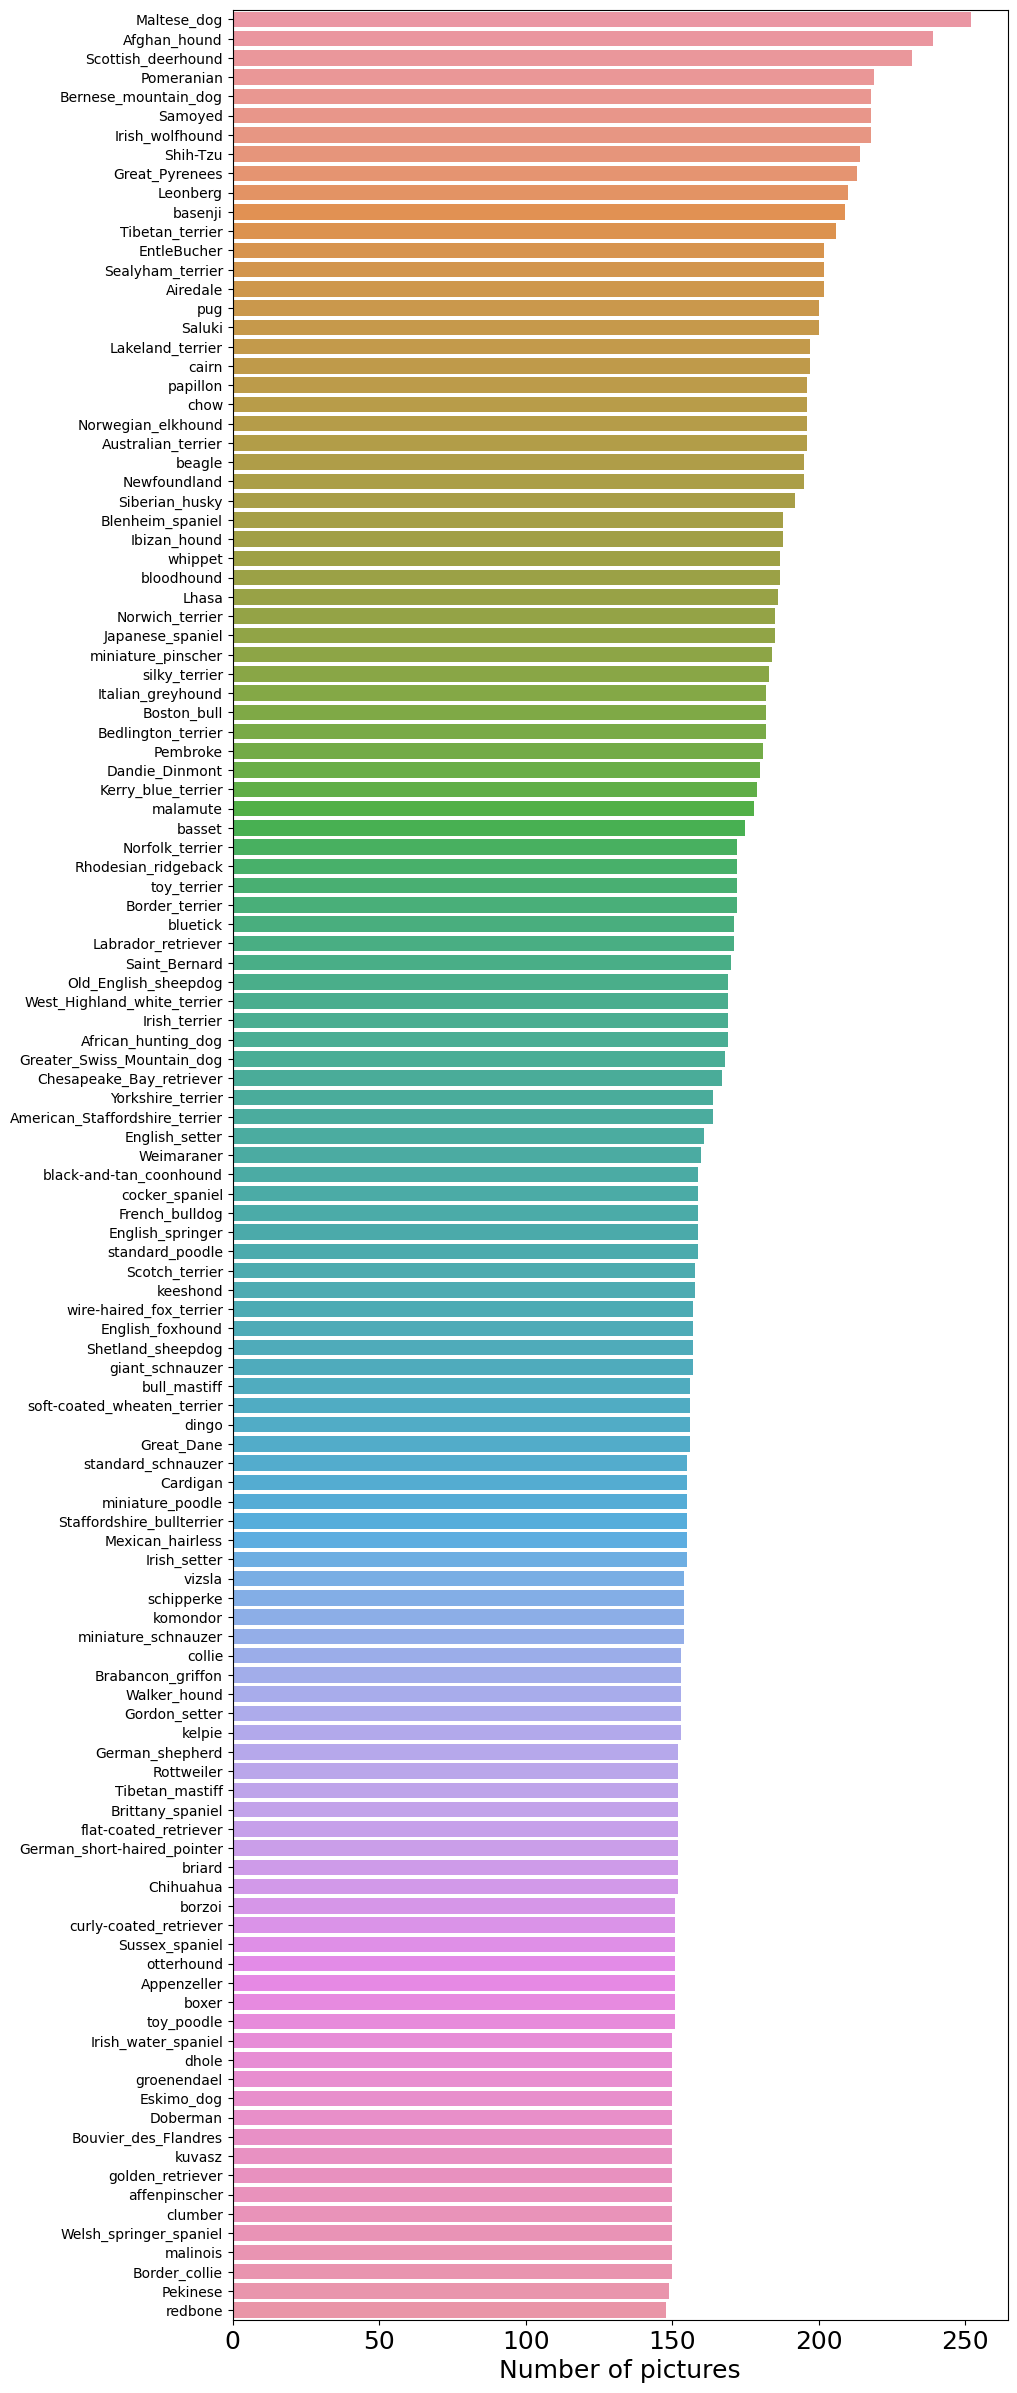

In [95]:
print(f"The number of remaining pictures is {df_breeds.num_pictures.sum()}")

plt.figure(figsize=(10,30))
sns.barplot(x=df_breeds.num_pictures,
            y=df_breeds.index)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=10)
plt.xlabel('Number of pictures', fontsize=18)
plt.show()

## Cropping 

**Ici on on découpe toutes les images du dataset pour avoir les chiens au centre de l'image**

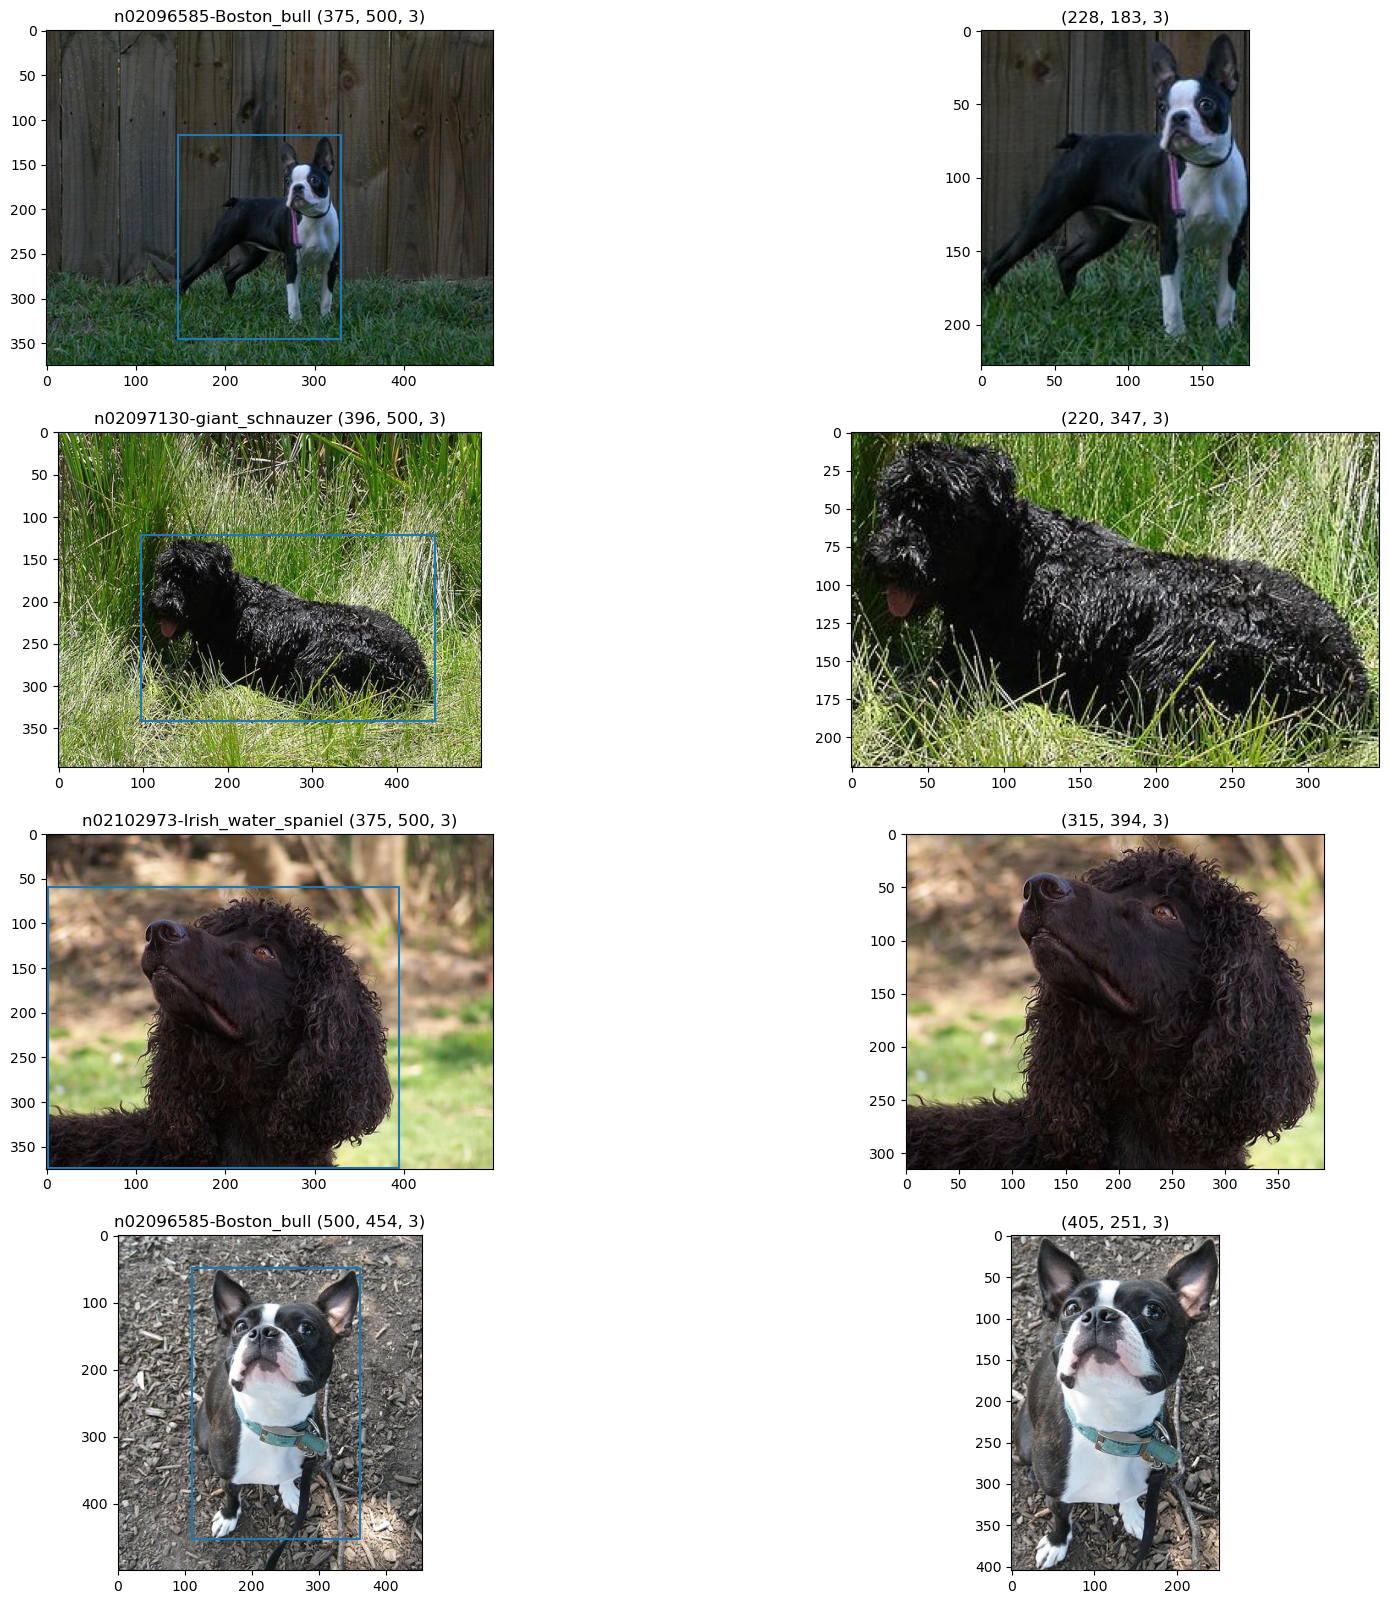

In [97]:
plt.figure(figsize=(20, 20))
for i in range(4):
    breed = np.random.choice(breed_names)
    dog   = np.random.choice(os.listdir(annotations_dir + breed))
    xmin, xmax, ymin, ymax = dog_breed_annotations(dog, breed)
    img      = plt.imread(images_dir + breed + '/' + dog + '.jpg')
    crop_img = crop_image(breed, dog, img)
    
    ## Plot image and annotations
    plt.subplot(421 + (i*2))
    plt.imshow(img)  
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    plt.title("{} {}".format(breed,img.shape))
    
    ## Plot cropped images    
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)
    plt.title("{}".format(crop_img.shape))

### Store newly cropped images

In [98]:
pwd

'/Users/souha_kassab/OC_P6/code/notebooks'

In [99]:
crop_dir = 'Data_all_cropped/'
if not os.path.exists(crop_dir):
    os.mkdir(crop_dir)
else:
    shutil.rmtree(crop_dir)

In [122]:
if crop_dir not in os.listdir():
    os.mkdir(crop_dir)
    
for breed_name in breed_names:
    os.mkdir(crop_dir + breed_name)
    
print('Created {} folders to store cropped images of the different breeds.'\
      .format(len(os.listdir(crop_dir))))

Created 241 folders to store cropped images of the different breeds.


In [110]:
from PIL import Image

for_all_start = time.time()

for breed in tqdm.tqdm(os.listdir(crop_dir), total=len(os.listdir(crop_dir))):
    for file in os.listdir(annotations_dir + breed):
        img = Image.open(images_dir + breed + '/' + file + '.jpg')
        xmin, xmax, ymin, ymax = dog_breed_annotations(file, breed)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save(crop_dir + breed + '/' + file + '.jpg')
    breed_end = time.time()

for_all_end = time.time()
print(f"Total elapsed time is {for_all_end - for_all_start}")

  0%|▏                                          | 1/241 [00:00<01:37,  2.47it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/souha_kassab/OC_P6/static/data/Annotation/Australian_terrier'

### Show random image in cropped dir

In [112]:
r = np.random.choice(range(len(breed_names)))
rand_img = plt.imread(crop_dir + breed_names[r] + '/' + 
                      np.random.choice(os.listdir(crop_dir + breed_names[r])))

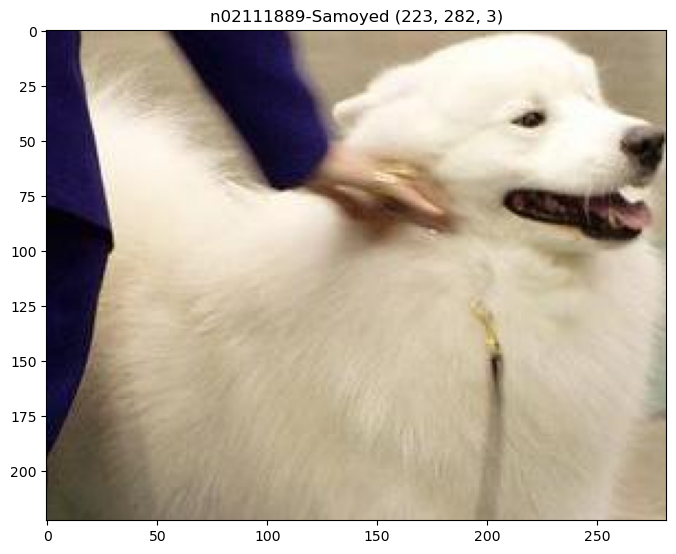

In [113]:
# Plot
plt.figure(figsize=(8,8))
plt.title("{} {}".format(breed_names[r],rand_img.shape))
plt.imshow(rand_img) 
plt.show()

## Sous-échantillon du dataset original  

In [151]:
# new images_dir:
#images_dir = crop_dir
Subimages_dir = crop_dir

###  Create dir

In [152]:
sampl_path = 'Data_sample_B20_n0/'
if not os.path.exists(sampl_path):
    os.mkdir(sampl_path)
else:
    shutil.rmtree(sampl_path)
    os.mkdir(sampl_path)

### process...

In [153]:
nb_breed          = 20 #len(reduced_breed_names)

# list of random breeds
breedLists = list(np.arange(len(breed_names)))

breedLists = random.sample(breedLists,nb_breed)
# breedLists
breedNames = [breed_names[breed] for breed in breedLists] 
# breedNames
for breedName in breedNames:
    print(f"breedName {breedName} length is {len(os.listdir(Subimages_dir + breedName))}")
    source_path = Subimages_dir + breedName
    destin_path = sampl_path + breedName[10:]
#     print(destin_path)
    destination = shutil.copytree(source_path, destin_path) 

breedName n02098105-soft-coated_wheaten_terrier length is 156
breedName n02094433-Yorkshire_terrier length is 164
breedName n02086240-Shih-Tzu length is 214
breedName n02097298-Scotch_terrier length is 158
breedName n02102480-Sussex_spaniel length is 151
breedName n02115641-dingo length is 156
breedName n02111889-Samoyed length is 218
breedName n02097209-standard_schnauzer length is 155
breedName n02108000-EntleBucher length is 202
breedName n02096585-Boston_bull length is 182
breedName n02087394-Rhodesian_ridgeback length is 172
breedName n02113624-toy_poodle length is 151
breedName n02107312-miniature_pinscher length is 184
breedName n02088238-basset length is 175
breedName n02109961-Eskimo_dog length is 150
breedName n02096294-Australian_terrier length is 196
breedName n02086910-papillon length is 196
breedName n02092002-Scottish_deerhound length is 232
breedName n02110063-malamute length is 178
breedName n02102318-cocker_spaniel length is 159


In [154]:
# Count the number of classes (dogs breeds)
reduced_breed_names = os.listdir(sampl_path)
print("Number of breeds in dataset:", (len(reduced_breed_names)))

Number of breeds in dataset: 20


### Show random image in data subset

In [155]:
check_dir = sampl_path # + 'train/'

In [156]:
# Choose random image
r = np.random.choice(range(len(reduced_breed_names)))
rand_img = plt.imread(check_dir + reduced_breed_names[r] + '/' + 
                      np.random.choice(os.listdir(check_dir + reduced_breed_names[r])))

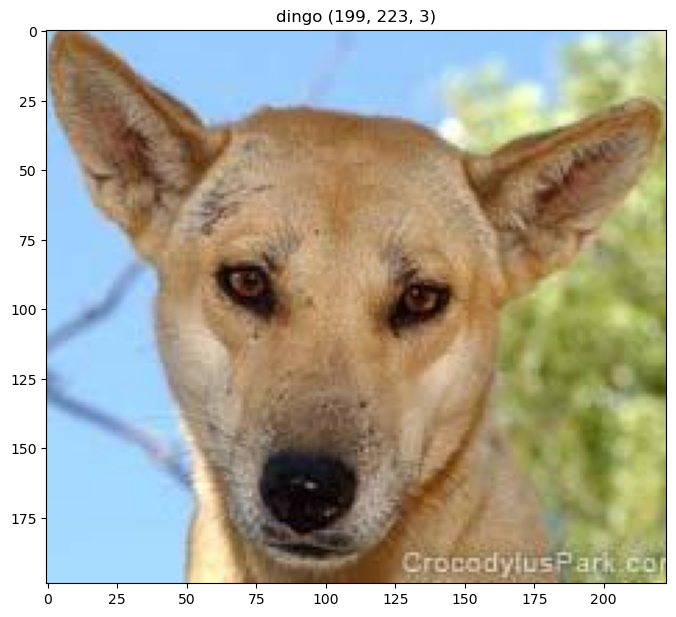

In [157]:
# Plot
plt.figure(figsize=(8,8))
plt.title("{} {}".format(reduced_breed_names[r],rand_img.shape))
plt.imshow(rand_img) 
plt.show()